In [1]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import sklearn.utils


samples = []

with open('learned_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


        

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
    

def generator(samples, batch_size):
    
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0,num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images =[]
            angles =[]
        
            for batch_sample in batch_samples:
    # Center Camera
                
                filename_c = 'learned_data/IMG/'+batch_sample[0].split('\\')[-1]
                image_c = cv2.imread(filename_c)
                image_center = cv2.cvtColor(image_c, cv2.COLOR_BGR2RGB)
                image_flipped = np.fliplr(image_center)
                images.append(image_center)
                images.append(image_flipped)
    
                measurement_center = np.float64(batch_sample[3])
                measurement_center_flipped = -np.copy(measurement_center)
                angles.append(measurement_center)
                angles.append(measurement_center_flipped)
    
    # Correction
    
                correction = 0.09

    #Left Camera
    
                filename_l = 'learned_data/IMG/'+batch_sample[1].split('\\')[-1]
                image_l = cv2.imread(filename_l)
                image_left = cv2.cvtColor(image_l, cv2.COLOR_BGR2RGB)
                images.append(image_left)
    
                measurement_left = np.float64(batch_sample[3]) + correction
                angles.append(measurement_left)
    
    #Right Camera
    
                filename_r = 'learned_data/IMG/'+batch_sample[2].split('\\')[-1]
                image_r = cv2.imread(filename_r)
                image_right = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
                images.append(image_right)
    
                measurement_right = np.float64(batch_sample[3]) - correction
                angles.append(measurement_right)
    
   
    
    
    
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle (X_train, y_train)


#X_train = np.array(images)
#print(np.shape(X_train))  
#plt.imshow(X_train[28])
#y_train = np.array(measurements)

In [2]:
train_generator = generator(train_samples, batch_size=10)
validation_generator = generator(validation_samples, batch_size=10)

In [32]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Lambda, Dropout, Convolution2D, MaxPooling2D, Cropping2D

import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

model.add(Convolution2D(24,5,5,subsample=(2,2), activation="relu")) 
model.add(Dropout(0.2))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation="relu"))
model.add(Dropout(0.2))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation="relu")) 
model.add(Dropout(0.2))

model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Dropout(0.2))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

#model.fit(X_train,y_train,validation_split=0.2, shuffle=True, nb_epoch=5)

model.fit_generator(train_generator, samples_per_epoch= len(train_samples),validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=5)

model.save('model_gen.h5')


Epoch 1/5
3640/3627 [==============================] - 11s - loss: 0.0195 - val_loss: 0.0194
Epoch 2/5
3640/3627 [==============================] - 10s - loss: 0.0163 - val_loss: 0.0128
Epoch 3/5
3628/3627 [==============================] - 10s - loss: 0.0141 - val_loss: 0.0147
Epoch 4/5
3640/3627 [==============================] - 10s - loss: 0.0137 - val_loss: 0.0165
Epoch 5/5
3640/3627 [==============================] - 9s - loss: 0.0131 - val_loss: 0.0148


In [33]:
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
cropping2d_2 (Cropping2D)        (None, 65, 320, 3)    0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 158, 24)   1824        cropping2d_2[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 31, 158, 24)   0           convolution2d_6[0][0]            
___________________________________________________________________________________________

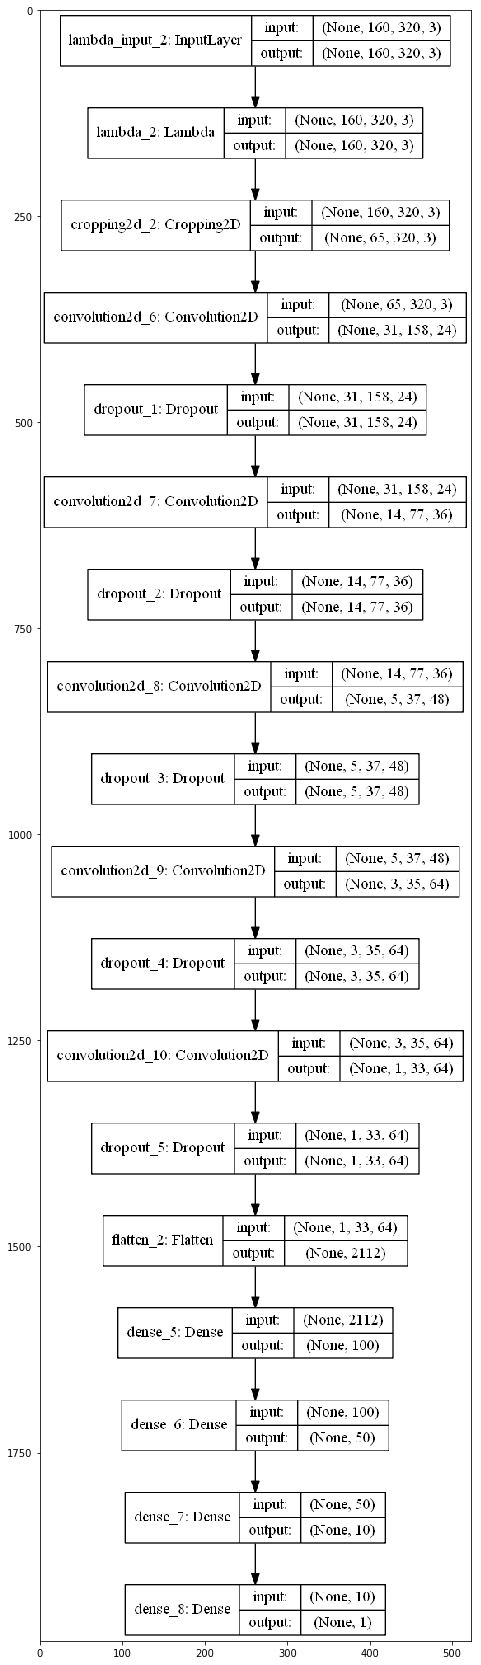

In [48]:
import pydot
from IPython.display import display
from keras.utils.visualize_util import plot
plot(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model_img = cv2.imread('model_plot.png')
plt.rcParams['figure.figsize'] = [10, 30]

plt.imshow(model_img, aspect='equal')

